# <center>Hotel's customers dataset EDA and clustering.</center>

<div>
<img src="https://images.pexels.com/photos/3771110/pexels-photo-3771110.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260" width="900"/>
</div>

Hello!<br>
&emsp;In this notebook we will take a look at a real-life dataset of customers (guests) of one of the four-star hotels in Lisbon, Portugal.<br> The dataset contains over 83000 records with behavioral, demographic and geographic information, gathered over 3 years, from 2015 to 2018.<br>
&emsp;After exploring the data we will try to use some of clustering algorithms to make a segmentation of customers. Clustering is the process of dividing the entire data into groups (also known as clusters) based on the patterns in the data.<br>
The dataset is available [here](http://dx.doi.org/10.17632/j83f5fsh6c.1), and the description [here](https://www.sciencedirect.com/science/article/pii/S2352340920314645#sec0004).<br> Let's get into it!

### Table of content:<br>

&emsp;[1. Data](#data)<br>
&emsp;[2. Columns description](#cols)<br>
&emsp;[3. Visualizations](#viz)<br>
&emsp;[4. Data preparation](#dataprep)<br>
&emsp;[5. KMeans](#kmeans)<br>
&emsp;[6. BIRCH](#birch)<br>
&emsp;[7. Gaussian Mixture Model](#gmm)<br>
&emsp;[8. Averages comparison](#avg)<br>
&emsp;[9. Conclusions](#conc)<br>

In [1]:
#libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as shc

## Data
<a id='data'></a>

In [2]:
df = pd.read_csv('HotelCustomersDataset.tsv', sep='\t')

In [3]:
pd.options.display.max_columns = None
df.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,51.0,150,0x8E0A7AF39B633D5EA25C3B7EF4DFC5464B36DB7AF375...,0x71568459B729F7A7ABBED6C781A84CA4274D571003AC...,45,371.0,105.3,1,0,3,8,5,151,1074,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1095,0x21EDE41906B45079E75385B5AA33287CA09DE1AB86DE...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...,61,280.0,53.0,0,0,1,10,5,1100,1100,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,DEU,31.0,1095,0x31C5E4B74E23231295FDB724AD578C02C4A723F4BA2B...,0xC7CF344F5B03295037595B1337AC905CA188F1B5B3A5...,0,0.0,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,FRA,60.0,1095,0xFF534C83C0EF23D1CE516BC80A65D0197003D27937D4...,0xBD3823A9B4EC35D6CAF4B27AE423A677C0200DB61E82...,93,240.0,60.0,0,0,1,10,5,1100,1100,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,FRA,51.0,1095,0x9C1DEF02C9BE242842C1C1ABF2C5AA249A1EEB4763B4...,0xE175754CF77247B202DD0820F49407C762C14A603B3A...,0,0.0,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(83590, 31)

83590 instances. You can see that 'name' and 'document ID' was changed to SHA2–256 hash string to allow customer's anonymization.<br>
From the dataset description we read the following ethics statement:<br><br>
>&emsp;<i>Given that the hotel providing the data requested anonymity and due to the preservation of personal data, such as name, ID number and date of birth, every effort was made to anonymize or transform fields that directly or indirectly allowed identification of the hotel or the hotel's customers. Nevertheless, it was ensured that the data maintained its original properties, such as the existence of duplicates, outliers, missing values, among others. In this way, the authors guarantee the anonymity and privacy of the data, without influencing its quality for the appropriate types of use.</i>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83590 entries, 0 to 83589
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    83590 non-null  int64  
 1   Nationality           83590 non-null  object 
 2   Age                   79811 non-null  float64
 3   DaysSinceCreation     83590 non-null  int64  
 4   NameHash              83590 non-null  object 
 5   DocIDHash             83590 non-null  object 
 6   AverageLeadTime       83590 non-null  int64  
 7   LodgingRevenue        83590 non-null  float64
 8   OtherRevenue          83590 non-null  float64
 9   BookingsCanceled      83590 non-null  int64  
 10  BookingsNoShowed      83590 non-null  int64  
 11  BookingsCheckedIn     83590 non-null  int64  
 12  PersonsNights         83590 non-null  int64  
 13  RoomNights            83590 non-null  int64  
 14  DaysSinceLastStay     83590 non-null  int64  
 15  DaysSinceFirstStay 

Columns description:<br>
<ul>
    <li>'ID' - customer's ID.</li>
    <li>'Age' - customer's age.</li>
    <li>'Nationality' - Country of origin in ISO 3155–3:2013 format.</li>
    <li>'DaysSinceCreation' - number of days elapsed between the creation date and the last day of the extraction period.</li>
    <li>'NameHash' - customer's hashed name.</li>
    <li>'DocIDHash' - customer's hashed document ID.</li>
    <li>'AverageLeadTime' - average number of days elapsed between the customer's booking date and arrival date.</li>
    <li>'LodgingRevenue' - total amount spent on lodging expenses by the customer in euros.</li>
    <li>'OtherRevenue' - total amount spent on other expenses by the customer in euros.</li>
    <li>'BookingsCanceled' - number of bookings the customer made but subsequently canceled (informed the hotel).</li>
    <li>'BookingsNoShowed' - number of bookings the customer made but didn't show up.</li>
    <li>'BookingsCheckedIn' - number of bookings the customer made, and which end up with a staying.</li>
    <li>'PersonsNights' - total number of persons/nights that the costumer stayed at the hotel.</li>
    <li>'RoomNights' - total of room/nights the customer stayed at the hotel.</li>
    <li>'DaysSinceLastStay' - number of days elapsed between the last day of the extraction and the customer's last arrival date (-1 indicates the customer never stayed at the hotel).</li>
    <li>'DaysSinceFirstStay' - number of days elapsed between the last day of the extraction and the customer's first arrival date (-1 indicates the customer never stayed at the hotel).</li>
    <li>'DistributionChannel' - distribution channel usually used by the customer to make bookings at the hotel.</li>
    <li>'MarketSegment' - current market segment of a customer.</li>
    <li> All of SR___ columns are indications if the customer usually asks for given extras/change.</li>
 </ul>
 <a id='cols'></a>

In [6]:
df.isna().sum()

ID                         0
Nationality                0
Age                     3779
DaysSinceCreation          0
NameHash                   0
DocIDHash                  0
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DaysSinceLastStay          0
DaysSinceFirstStay         0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64

3779 values missing in 'Age' column. We will have to deal with this later, in clustering part.

I will create some additional columns that will help us get more insights about the data.<br>
<ul>
    <li>'TotalRevenue' - total amount spent by a customer on lodging (room, crib, and other related lodging expenses) and other expenses such as food, beverage, spa etc.</li>
    <li>'PersonRoomNights' - created by dividing 'PersonsNights' by 'RoomNights' to get the estimated number of people per room.</li>
    <li>'AgeGroups' - age groups of '0-20', '21-40', '41-60', '60+' with missing values grouped as 'Unknown' (that includes negative values as well)</li>

In [7]:
df['TotalRevenue'] = df['LodgingRevenue'] + df['OtherRevenue']

df['PersonsRoomNight'] = df['PersonsNights'] / df['RoomNights']
df['PersonsRoomNight'].fillna(0, inplace=True)

df['AgeGroups'] = pd.cut(df['Age'], bins=[-1, 20, 40, 60, 125], labels=['0-20', '21-40', '41-60', '60+'])
df['AgeGroups'] = df['AgeGroups'].cat.add_categories('Unknown')
df['AgeGroups'].fillna('Unknown', inplace=True)

avg_by_age = df.groupby('AgeGroups').mean()
sum_by_age = df.groupby('AgeGroups').sum()
avg_by_nat = df.groupby('Nationality').mean()

## A little bit of visualization.
<a id='viz'></a>

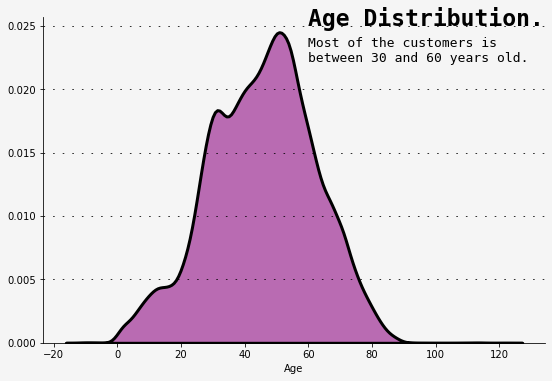

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.kdeplot(df['Age'], shade=True, color='#AB49A2', alpha=0.8, linewidth=3, edgecolor='black')
sns.despine()
fig.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')
ax.set_ylabel('')
ax.set_xlabel('Age')
ax.grid(False)
# ax.yaxis.set_ticklabels([])
ax.grid(which='both', axis='y', color='black', linestyle=':', dashes=(2,10))
ax.text(60, 0.025, 'Age Distribution.', fontsize=23, fontweight='bold', fontfamily='monospace')
ax.text(60, 0.0222, 'Most of the customers is \nbetween 30 and 60 years old.', fontsize=13, fontfamily='monospace')
plt.show()

In [9]:
df['Age'].min(), df['Age'].max()

(-11.0, 122.0)

In [10]:
sum(df['Age'] < 1)

59

Apart from missing values we have some negative numbers as well which obviously is a mistake.

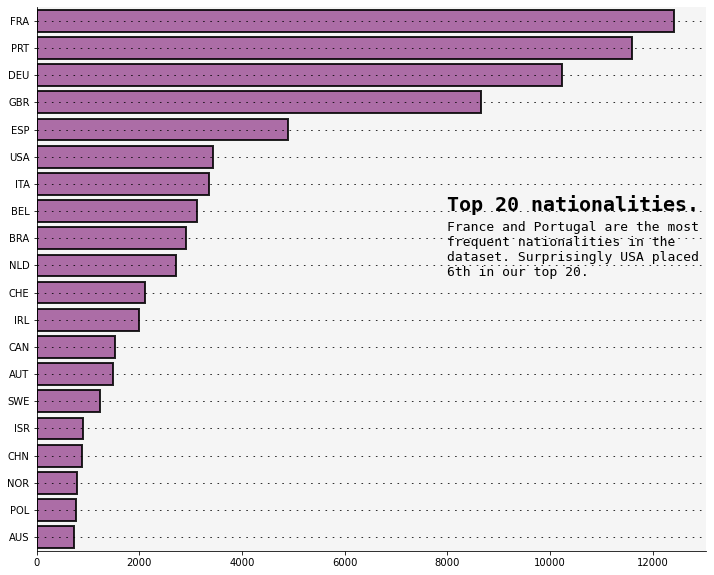

In [11]:
AB49A2fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=df, y='Nationality', 
              order=df['Nationality'].value_counts(sort=True).index[:20], 
              color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black')
sns.despine()
fig.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')
ax.set_ylabel('')
ax.set_xlabel('')
ax.grid(False)
ax.grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
ax.text(8000, 7, 'Top 20 nationalities.', fontsize=20, fontweight='bold', fontfamily='monospace')
ax.text(8000, 9.4, 'France and Portugal are the most \nfrequent nationalities in the \ndataset. Surprisingly USA placed \n6th in our top 20.', fontsize=13, fontfamily='monospace')
plt.show()

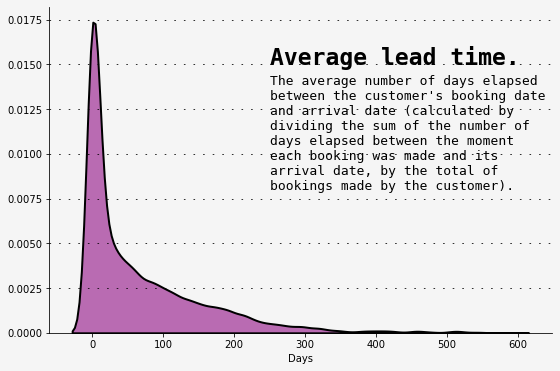

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.kdeplot(df['AverageLeadTime'], shade=True, color='#AB49A2', alpha=0.8, linewidth=2, edgecolor='black')
sns.despine()
fig.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')
ax.set_ylabel('')
ax.set_xlabel('Days')
ax.grid(False)
ax.grid(which='both', axis='y', color='black', linestyle=':', dashes=(2,10))
ax.text(250, 0.0150, 'Average lead time.', fontsize=23, fontweight='bold', fontfamily='monospace')
ax.text(250, 0.008, 'The average number of days elapsed \nbetween the customer\'s booking date \nand arrival date (calculated by \ndividing the sum of the number of \ndays elapsed between the moment \neach booking was made and its \narrival date, by the total of \nbookings made by the customer).', fontsize=13, fontfamily='monospace')
plt.show()

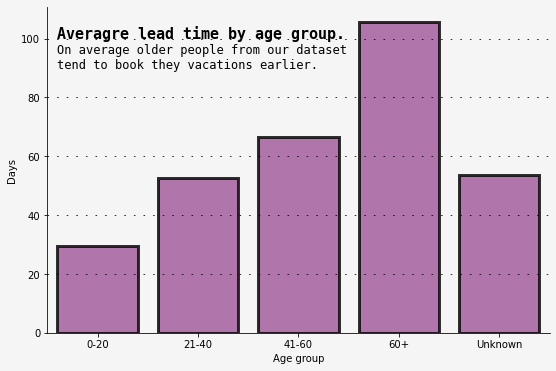

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(data=avg_by_age, x=avg_by_age.index, y='AverageLeadTime', 
            color='#AB49A2', alpha=0.8, linewidth=3, edgecolor='k')
sns.despine()
fig.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age group')
ax.set_ylabel('Days')
ax.grid(False)
ax.grid(which='both', axis='y', color='black', linestyle=':', dashes=(2,10))
ax.text(-0.4, 100, 'Averagre lead time by age group.', fontsize=15, fontweight='bold', fontfamily='monospace')
ax.text(-0.4, 90, 'On average older people from our dataset \ntend to book they vacations earlier.', fontsize=12, fontfamily='monospace')
plt.show()

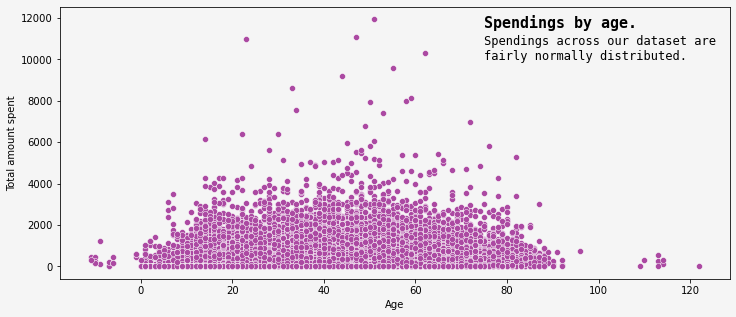

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.set_facecolor('#F5F5F5')

sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], color='#AB49A2')
# sns.kdeplot(x=df['Age'], y=df['TotalRevenue'], color='k')
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age')
ax.set_ylabel('Total amount spent')
ax.text(75, 11500, 'Spendings by age.', fontsize=15, fontweight='bold', fontfamily='monospace')
ax.text(75, 10000, 'Spendings across our dataset are \nfairly normally distributed.', fontsize=12, fontfamily='monospace')
plt.show()

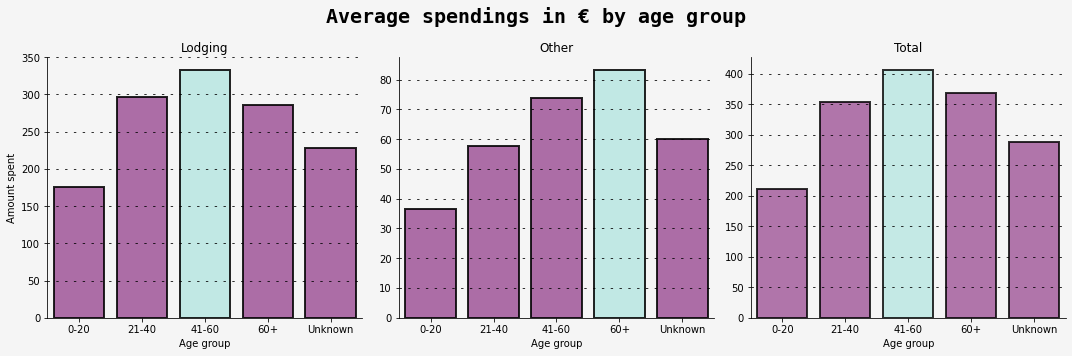

In [15]:
fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('#F5F5F5')

ax = [None for _ in range(3)]

ax[0] = plt.subplot2grid((1,3), (0,0), colspan=1)
ax[1] = plt.subplot2grid((1,3), (0,1), colspan=1)
ax[2] = plt.subplot2grid((1,3), (0,2), colspan=1)

sns.barplot(data=avg_by_age, x=avg_by_age.index, y='LodgingRevenue',
            alpha=0.85, linewidth=2, edgecolor='black', ax=ax[0], palette=['#AB49A2', 
                                                                          '#AB49A2', 
                                                                          '#B1EDE8', 
                                                                          '#AB49A2'])
ax[0].set_title('Lodging')
ax[0].set_ylabel('Amount spent')

sns.barplot(data=avg_by_age, x=avg_by_age.index, y='OtherRevenue', 
            alpha=0.85, linewidth=2, edgecolor='black', ax=ax[1], palette=['#AB49A2', 
                                                                          '#AB49A2', 
                                                                          '#AB49A2', 
                                                                          '#B1EDE8'])
ax[1].set_title('Other')
ax[1].set_ylabel('')

sns.barplot(data=avg_by_age, x=avg_by_age.index, y='TotalRevenue', 
            alpha=0.8, linewidth=2, edgecolor='black', ax=ax[2], palette=['#AB49A2', 
                                                                          '#AB49A2', 
                                                                          '#B1EDE8', 
                                                                          '#AB49A2'])
ax[2].set_title('Total')
ax[2].set_ylabel('')

for i in range(3):
    sns.despine()
    ax[i].set_facecolor('#F5F5F5')
    ax[i].set_xlabel('Age group')
    ax[i].xaxis.grid(False, which='major')
    ax[i].yaxis.grid(True, linestyle=':', color='black', dashes=(3, 8))

    plt.suptitle('Average spendings in € by age group', fontsize=20, fontweight='bold', fontfamily='monospace')
fig.tight_layout()
plt.show()

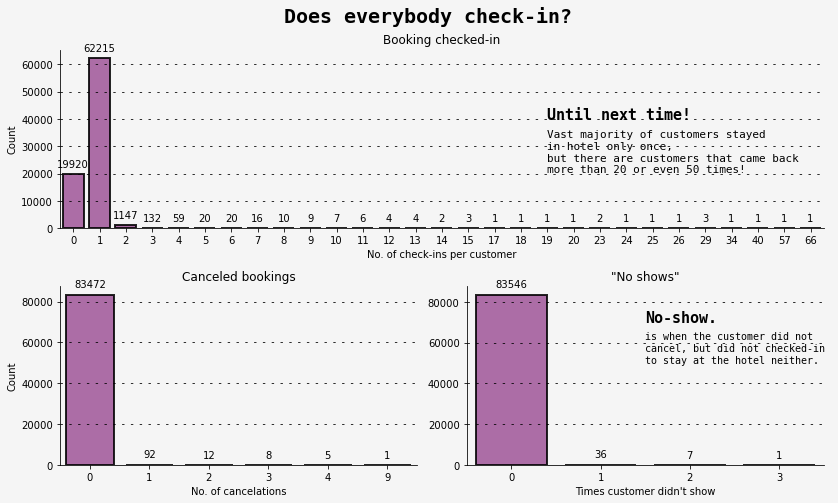

In [16]:
fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('#F5F5F5')

ax = [None for _ in range(6)] 

ax[0] = plt.subplot2grid((3,4), (0,0), colspan=4)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan=2)
ax[2] = plt.subplot2grid((3,4), (1,2), colspan=2)

g1 = sns.countplot(data=df, x='BookingsCanceled',
            color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black', ax=ax[1])

for p in g1.patches:
    g1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
ax[1].set_title('Canceled bookings')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('No. of cancelations')

g2 = sns.countplot(data=df, x='BookingsNoShowed',
            color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black', ax=ax[2])

for p in g2.patches:
    g2.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
ax[2].set_title('"No shows"')
ax[2].set_ylabel('')
ax[2].set_xlabel('Times customer didn\'t show')
ax[2].text(1.5, 70000, 'No-show.', fontsize=15, fontweight='bold', fontfamily='monospace')
ax[2].text(1.5, 50000, 'is when the customer did not \ncancel, but did not checked-in \nto stay at the hotel neither.', 
           fontsize=10, fontfamily='monospace')

g3 = sns.countplot(data=df, x='BookingsCheckedIn',
            color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black', ax=ax[0])

for p in g3.patches:
    g3.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
ax[0].set_title('Booking checked-in')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('No. of check-ins per customer')
ax[0].text(18, 40000, 'Until next time!', fontsize=15, fontweight='bold', fontfamily='monospace')
ax[0].text(18, 20450, 'Vast majority of customers stayed \nin hotel only once, \nbut there are customers that came back \nmore than 20 or even 50 times!', fontsize=11, fontfamily='monospace')

for i in range(3):
    sns.despine()
    ax[i].set_facecolor('#F5F5F5')
    ax[i].xaxis.grid(False, which='major')
    ax[i].yaxis.grid(True, linestyle=':', color='black', dashes=(3, 8))

plt.suptitle('Does everybody check-in?', fontsize=20, fontweight='bold', fontfamily='monospace')
plt.tight_layout()
plt.show()

&emsp;Data description about 'booking checked in' says: 'Number of bookings the customer made, and which end up with a staying'.<br> What does almost 20 thousands zeros means? If the customer didn't arrived but didn't cancel why isn't he/she included in 'no-shows' group?

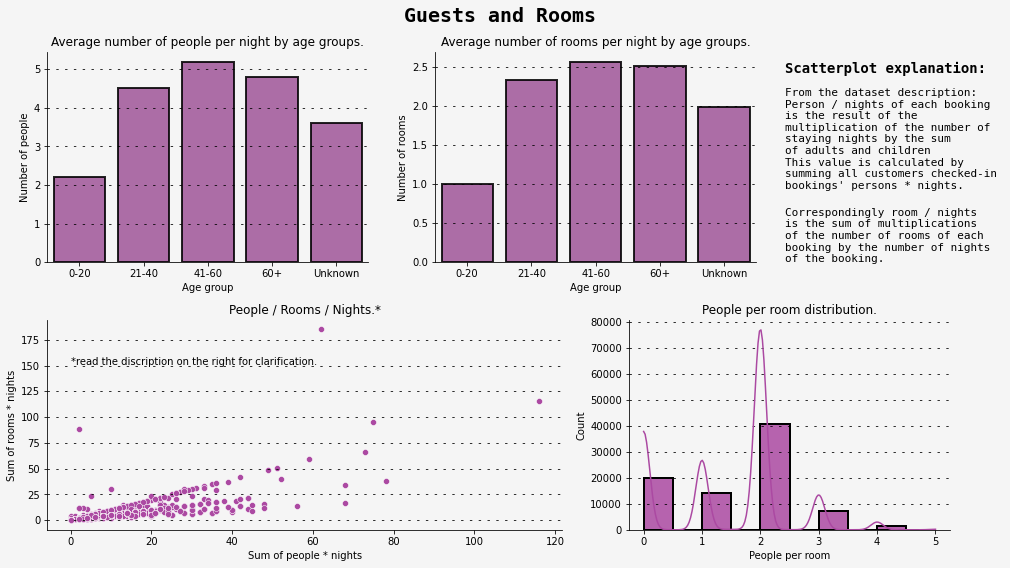

In [69]:
fig = plt.figure(figsize=(14, 8))
fig.set_facecolor('#F5F5F5')

ax = [None for _ in range(6)]

ax[0] = plt.subplot2grid((2,5), (1,0), colspan=3)
ax[1] = plt.subplot2grid((2,5), (0,0), colspan=2)
ax[2] = plt.subplot2grid((2,5), (0,2), colspan=2)
ax[3] = plt.subplot2grid((2,5), (0,4), colspan=1)
ax[4] = plt.subplot2grid((2,5), (1,3), colspan=2)

sns.scatterplot(data=df, x='PersonsNights', y='RoomNights', color='#AB49A2', ax=ax[0])
ax[0].set_title('People / Rooms / Nights.*')
ax[0].set_ylabel('Sum of rooms * nights')
ax[0].set_xlabel('Sum of people * nights')
ax[0].text(0, 151, '*read the discription on the right for clarification.')

sns.barplot(data=avg_by_age, x=avg_by_age.index, y='PersonsNights', 
            color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black', ax=ax[1])
ax[1].set_title('Average number of people per night by age groups.')
ax[1].set_ylabel('Number of people')
ax[1].set_xlabel('Age group')

sns.barplot(data=avg_by_age, x=avg_by_age.index, y='RoomNights', 
            color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black', ax=ax[2])
ax[2].set_title('Average number of rooms per night by age groups.')
ax[2].set_ylabel('Number of rooms')
ax[2].set_xlabel('Age group')

sns.histplot(df['PersonsRoomNight'], kde=True, bins=10,
            color='#AB49A2', alpha=0.85, linewidth=2, edgecolor='black', ax=ax[4])
ax[4].set_title('People per room distribution.')
ax[4].set_ylabel('Count')
ax[4].set_xlabel('People per room')

for i in [0, 1, 2, 4]:
    sns.despine()
    ax[i].set_facecolor('#F5F5F5')
    ax[i].xaxis.grid(False, which='major')
    ax[i].yaxis.grid(True, linestyle=':', color='black', dashes=(3, 8))

ax[3].set_facecolor('#F5F5F5')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].text(-0.3, 0.9, 'Scatterplot explanation:', fontsize=14, fontweight='bold', fontfamily='monospace')
ax[3].text(-0.3, 0.35, 'From the dataset description: \nPerson / nights ' \
           'of each booking \nis the result of the \nmultiplication ' \
           'of the number of \nstaying nights by the sum \nof adults and children ' \
           '\nThis value is calculated by \nsumming all customers checked-in \nbookings\' persons * nights.', 
           fontsize=11, fontfamily='monospace')
ax[3].text(-0.3, 0, 'Correspondingly room / nights \nis the sum of multiplications ' \
           '\nof the number of rooms of each \nbooking by the number of nights \nof the booking.', 
           fontsize=11, fontfamily='monospace')

plt.suptitle('Guests and Rooms', fontsize=20, fontweight='bold', fontfamily='monospace')
plt.tight_layout()
plt.show()

&emsp;To be honest I shamefully admit that I don't completely understand some of the messurements. In the dataset there is no information of how many nights each customer have stayed. The trend seams obvious: more people = more rooms, for example 10 person/nights and 5 room/nights most likely means 2 people stayed in one room for 5 nights (or 10 people in 5 rooms for one night), 9-3 similarly: 3 people, one room, 3 nights etc., but what about this:

In [70]:
df[['PersonsNights', 'RoomNights']].loc[df['RoomNights'] > 75]

,PersonsNights,RoomNights
2160,75,95
2757,62,185
4196,2,88
12952,116,116


&emsp;If we multiply the amount of people by amount of nights they have stayed and do the same for the rooms they have booked how come there is something like 2 persons/night and 88 room/nights? One of explanation that came to my mind is that maybe there were many rooms booked but a part of guests didn't showed up (but the rooms were for example already payed so it was uncancellable/not refundable). We could also try to get the number of nights by substracting the value from 'DaysSinceLastStay' from 'DaysSinceCreation' but it would only work for people that came once (although this is a vast majority of our customers).<br> &emsp;If you have any guess/explanation please put it in the comments below this notebook, thank You. 

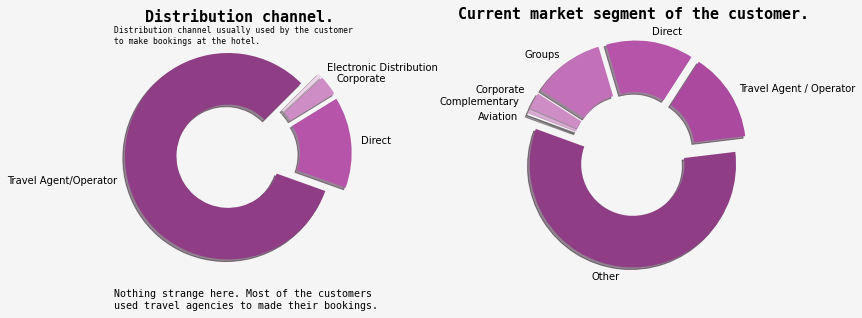

In [19]:
dist_channels = df['DistributionChannel'].value_counts()
market_segments = df['MarketSegment'].value_counts()
ms_labels = ['Other', 'Travel Agent / Operator', 'Direct', 'Groups', 'Corporate\n', 'Complementary\n', '\nAviation']
fig = plt.figure(figsize=(12, 6), facecolor='#F5F5F5')
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

cmap1 = ['#8F3D84', '#B654A9', '#CE8DC5', '#EDD4EA',]
cmap2 = ['#8F3D84', '#AB499E', '#B654A9', '#C270B7', '#CE8DC5', '#DAA9D4', '#F9F1F8']

ax0.pie(dist_channels, labels=dist_channels.index, explode=[0.1, 0.1, 0.1, 0.1], 
        colors=cmap1, wedgeprops=dict(width=0.5), shadow=True, startangle=45)

ax0.text(-0.9, 1.28, 'Distribution channel.', fontsize=15, fontweight='bold', fontfamily='monospace')
ax0.text(-1.2, 1.07, 'Distribution channel usually used by the customer \nto make bookings at the hotel.', 
         fontsize=8, fontfamily='monospace')
ax0.text(-1.2, -1.5, 'Nothing strange here. Most of the customers \nused travel agencies to made their bookings.', 
         fontsize=10, fontfamily='monospace')

ax1.pie(market_segments, labels=ms_labels, explode=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
        colors=cmap2, wedgeprops=dict(width=0.5), shadow=True, startangle=160)
ax1.set_title('Current market segment of the customer.', fontsize=15, fontweight='bold', fontfamily='monospace')
# ax1.text(-0.9, 1.25, 'Market segment', fontsize=15, fontweight='bold', fontfamily='monospace')
# ax1.text(-1.2, 1.07, 'Current market segment of the customer.', 
#          fontsize=8, fontfamily='monospace')


plt.tight_layout()
plt.show()

In [20]:
requests_cols = ['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 
                 'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed', 
                 'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom']

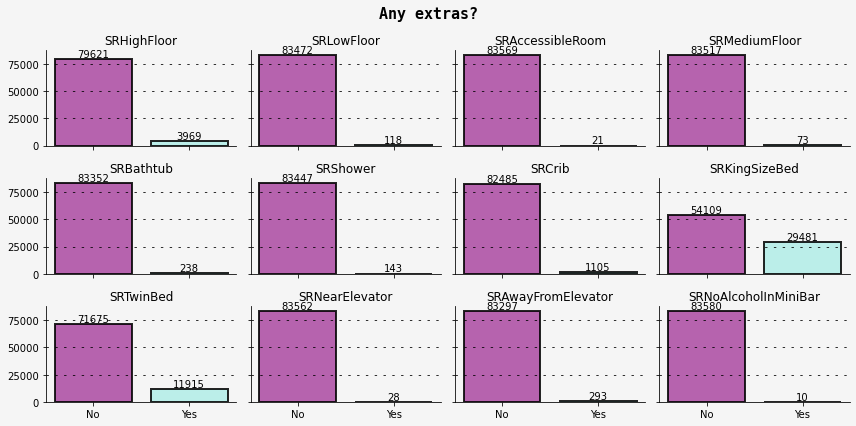

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(12, 6), sharex=True, sharey=True, squeeze=False)
fig.set_facecolor('#F5F5F5')

for i, ax in enumerate(axes.flatten()):
    col = requests_cols[i]
    counts = df[col].value_counts()
    g = ax.bar(counts.index, counts.values, color=['#AB49A2', '#B1EDE8'], 
               alpha=0.85, edgecolor='k', linewidth=2)
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'top', \
                                               xytext = (0, 10), textcoords = 'offset points')
    ax.set_title(f'{col}')
    ax.set_facecolor('#F5F5F5')
    plt.xticks([0, 1], ['No', 'Yes'])
    ax.xaxis.grid(False, which='major')
    ax.yaxis.grid(True, linestyle=':', color='black', dashes=(3, 8))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.suptitle('Any extras?', fontsize=15, fontweight='bold', fontfamily='monospace')
plt.tight_layout()
plt.show()

&emsp;As we can see majority of customers don't ask for anything. The most common requests are king size bed, twin bed, a crib and moving to a higher floor.

&emsp;After this brief exploration let's proceed with implementation of clustering algorithms.

## Data preparation for clustering.
<a id='dataprep'></a>

Since we have only the 'ID' column to identify our customer I will create a column with constant variable to help visualizing results.

In [22]:
df['Const'] = 'Constant'

In [23]:
df.head(3)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight,AgeGroups,Const
0,1,PRT,51.0,150,0x8E0A7AF39B633D5EA25C3B7EF4DFC5464B36DB7AF375...,0x71568459B729F7A7ABBED6C781A84CA4274D571003AC...,45,371.0,105.3,1,0,3,8,5,151,1074,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0,476.3,1.6,41-60,Constant
1,2,PRT,NaN,1095,0x21EDE41906B45079E75385B5AA33287CA09DE1AB86DE...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...,61,280.0,53.0,0,0,1,10,5,1100,1100,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,333.0,2.0,Unknown,Constant
2,3,DEU,31.0,1095,0x31C5E4B74E23231295FDB724AD578C02C4A723F4BA2B...,0xC7CF344F5B03295037595B1337AC905CA188F1B5B3A5...,0,0.0,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,21-40,Constant


Droping unnecessary columns.

In [24]:
data_prep = df.drop(['ID', 'Nationality', 'LodgingRevenue', 'OtherRevenue', 'DaysSinceCreation', 'NameHash', 
               'DocIDHash', 'DaysSinceLastStay', 'DaysSinceFirstStay', 'AgeGroups', 'Const'], axis=1)
data_prep.head()

,Age,AverageLeadTime,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight
0,51.0,45,1,0,3,8,5,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0,476.3,1.6
1,NaN,61,0,0,1,10,5,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,333.0,2.0
2,31.0,0,0,0,0,0,0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
3,60.0,93,0,0,1,10,5,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,300.0,2.0
4,51.0,0,0,0,0,0,0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


Filling <b>missing values</b> in 'age' column with mean and removing the negative values.

In [25]:
data_prep['Age'].fillna(df['Age'].mean(), inplace=True)
data_prep['Age'] = data_prep['Age'].astype(int)
neg_age = data_prep.loc[data_prep['Age'] < 1]
data_prep.drop(neg_age.index, inplace=True)
data_prep.shape

(83531, 24)

Getting <b>dummies</b> for categorical variables and creating final dataframe.

In [26]:
cat_cols = data_prep.select_dtypes(include='object')
list(cat_cols)

['DistributionChannel', 'MarketSegment']

In [27]:
cat_cols_dummies = pd.get_dummies(cat_cols, prefix=['Channel', 'Segment'], prefix_sep='')
cat_cols_dummies.head(3)

,ChannelCorporate,ChannelDirect,ChannelElectronic Distribution,ChannelTravel Agent/Operator,SegmentAviation,SegmentComplementary,SegmentCorporate,SegmentDirect,SegmentGroups,SegmentOther,SegmentTravel Agent/Operator
0,1,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,1


In [28]:
to_concat = data_prep.drop(['DistributionChannel', 'MarketSegment'], axis=1)
data = pd.concat([to_concat, cat_cols_dummies], axis=1)
data.head(3)

,Age,AverageLeadTime,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight,ChannelCorporate,ChannelDirect,ChannelElectronic Distribution,ChannelTravel Agent/Operator,SegmentAviation,SegmentComplementary,SegmentCorporate,SegmentDirect,SegmentGroups,SegmentOther,SegmentTravel Agent/Operator
0,51,45,1,0,3,8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,476.3,1.6,1,0,0,0,0,0,1,0,0,0,0
1,45,61,0,0,1,10,5,0,0,0,0,0,0,0,0,0,0,0,0,0,333.0,2.0,0,0,0,1,0,0,0,0,0,0,1
2,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1


Normalizing variables with <b>MinMaxScaler</b>.

In [29]:
scaler = MinMaxScaler()

In [30]:
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.41322314, 0.07809847, 0.11111111, ..., 0.        , 0.        ,
        0.        ],
       [0.36363636, 0.10526316, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.24793388, 0.00169779, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.42975207, 0.00169779, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.69421488, 0.18675722, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.09917355, 0.00169779, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [31]:
df_scaled = pd.DataFrame(data_scaled, columns=data.columns)
df_scaled.head()

,Age,AverageLeadTime,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight,ChannelCorporate,ChannelDirect,ChannelElectronic Distribution,ChannelTravel Agent/Operator,SegmentAviation,SegmentComplementary,SegmentCorporate,SegmentDirect,SegmentGroups,SegmentOther,SegmentTravel Agent/Operator
0,0.413223,0.078098,0.111111,0.0,0.045455,0.068966,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020385,0.32,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.363636,0.105263,0.000000,0.0,0.015152,0.086207,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014252,0.40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.247934,0.001698,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.487603,0.159593,0.000000,0.0,0.015152,0.086207,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012840,0.40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.413223,0.001698,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In the end I've decided to use only columns that I think are most suitable for our task (I've run following algorithms with complete scaled dataframe, the results were similar or even more messy).
<br> Dummies weren't necessary but I leave them for potential use in the future.

In [32]:
df.drop(neg_age.index, inplace=True)

Final dataframe

In [33]:
X = df_scaled[['Age', 'AverageLeadTime', 'PersonsNights', 'RoomNights', 'TotalRevenue']]

### KMeans cluster
<a id='kmeans'></a>

&emsp;One of the most popular clustering algorithms. K-means tries to group similar items in the form of clusters. The number of groups is represented by K.<br> The "Elbow Method" is one of the most popular methods to determine this optimal value of K. To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion (average of the squared distances from the cluster centers of the respective clusters) / inertia (sum of squared distances of samples to their closest cluster center) start decreasing in a linear fashion.

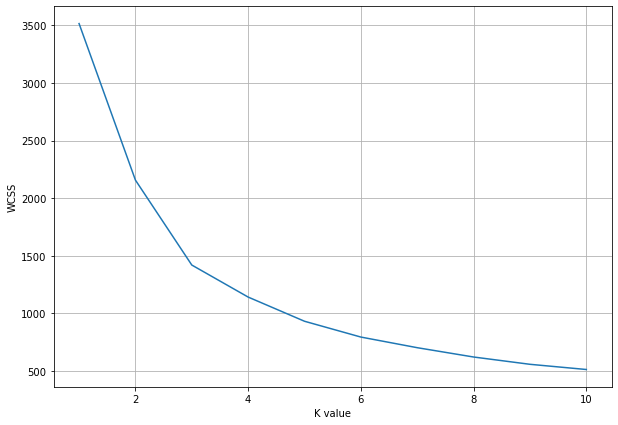

Wall time: 23.6 s


In [34]:
%%time

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(range(1, 11), wcss)
plt.xlabel('K value')
plt.ylabel('WCSS')
plt.show()

We see that the "elbow" point is for K=3 se we chose that value.

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [36]:
labels = kmeans.labels_
df['Kmean-Labels'] = labels
df['Kmean-Labels'].value_counts()

1    39320
2    28656
0    15555
Name: Kmean-Labels, dtype: int64

Visualize the labels in a strip plot.

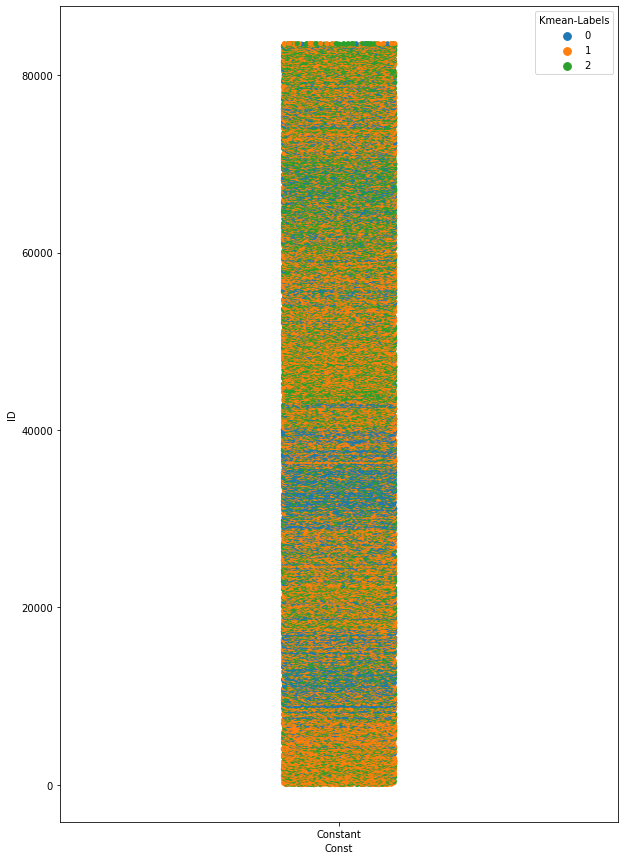

In [37]:
plt.figure(figsize=(10, 15))
sns.stripplot(x=df['Const'], y=df['ID'], hue=df['Kmean-Labels'])
plt.show()

That is definitely not the most beautiful plot. <br> Let's see how does the labels distribution looks on separated plots.

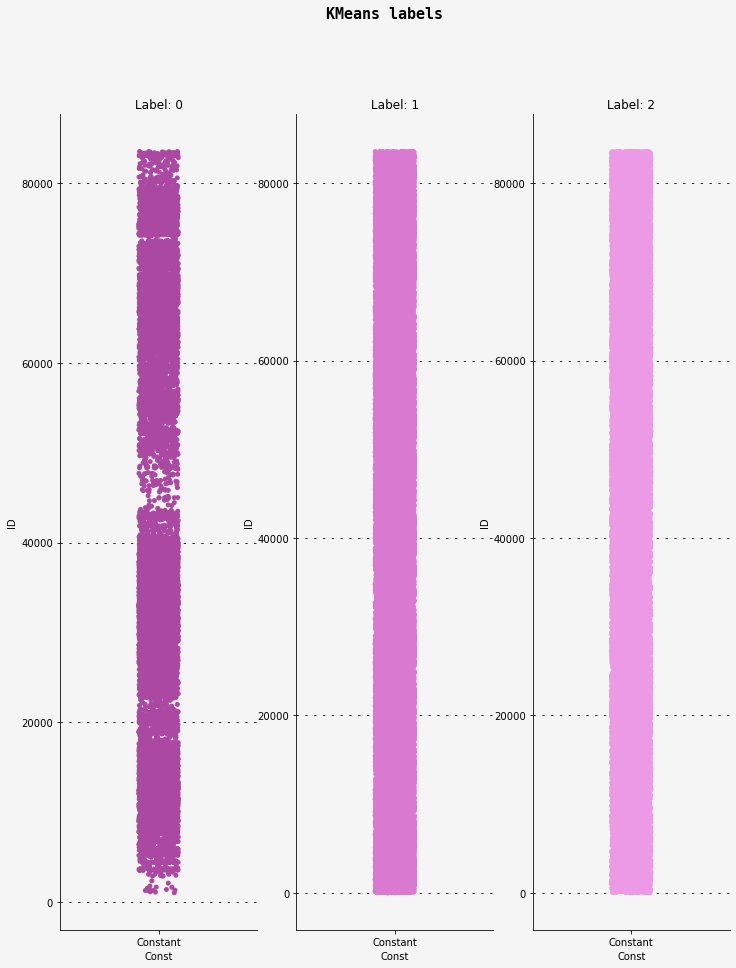

In [38]:
klabel0 = df.loc[df['Kmean-Labels']==0]
klabel1 = df.loc[df['Kmean-Labels']==1]
klabel2 = df.loc[df['Kmean-Labels']==2]

fig = plt.figure(figsize=(12, 15))
fig.set_facecolor('#F5F5F5')

ax = [None for _ in range(3)]

ax[0] = plt.subplot2grid((1,3), (0,0), colspan=1)
ax[1] = plt.subplot2grid((1,3), (0,1), colspan=1)
ax[2] = plt.subplot2grid((1,3), (0,2), colspan=1)

sns.stripplot(x=df['Const'], y=klabel0['ID'], ax=ax[0], color='#AB49A2')
sns.stripplot(x=df['Const'], y=klabel1['ID'], ax=ax[1], color='#d979d0')
sns.stripplot(x=df['Const'], y=klabel2['ID'], ax=ax[2], color='#ed9ae6')

for i in range(3):
    sns.despine()
    ax[i].set_title(f'Label: {i}')
    ax[i].set_facecolor('#F5F5F5')
    ax[i].xaxis.grid(False, which='major')
    ax[i].yaxis.grid(True, linestyle=':', color='black', dashes=(3, 8))

plt.suptitle('KMeans labels', fontsize=15, fontweight='bold', fontfamily='monospace')
plt.show()

Well, that didn't help a lot.<br>
We will use our previous plot of age/total spendings and apply labels to it.

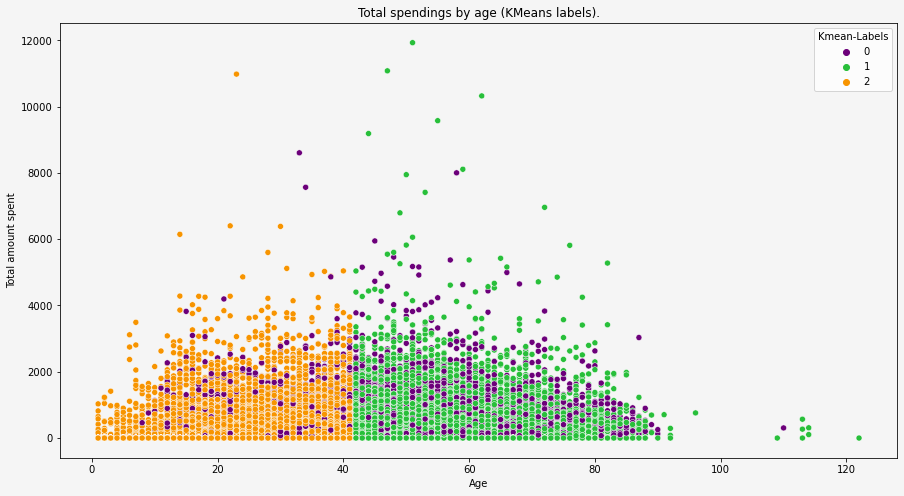

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor('#F5F5F5')

palette = ['#6c007a', '#28bf3a', '#f79400']
sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], hue=df['Kmean-Labels'], palette=palette)
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age')
ax.set_ylabel('Total amount spent')
plt.title('Total spendings by age (KMeans labels).')
plt.show()

&emsp;That presents the distribution of labels a little better but I am quite sceptical about this result due to the vertical split after 40 years of age.<br> It would be better to run KMeans with many iterations, with different settings and feature combinations (including outliers removal, PCA and even feature order) but we will not do that in this notebook.

Let's just take a look at average values of original data grouped by labels.

In [40]:
kmeans_avg = df.groupby('Kmean-Labels').mean()
kmeans_avg.drop('ID', axis=1, inplace=True)
kmeans_avg

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight
Kmean-Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,53.251455,496.910511,216.026808,419.765372,108.861748,0.000321,0.000000,1.012986,7.185214,3.420765,499.828608,500.297975,0.040051,0.001286,0.000257,0.000836,0.002122,0.002829,0.006172,0.347991,0.182578,0.000321,0.003472,0.000000,0.099518,528.627120,2.069602
1,55.563007,469.383113,31.831587,282.274324,64.321765,0.003484,0.001221,0.790844,4.318057,2.245015,408.799390,412.444507,0.044379,0.001907,0.000331,0.001017,0.002263,0.001577,0.004451,0.348118,0.124059,0.000483,0.004095,0.000051,0.091963,346.596089,1.413505
2,28.576633,408.847536,32.056288,256.268729,49.760434,0.000942,0.000174,0.682335,3.734017,1.941199,337.236111,338.635992,0.055800,0.000803,0.000140,0.000698,0.004048,0.001291,0.028197,0.361146,0.146392,0.000140,0.002722,0.000279,0.077540,306.029164,1.252563


&emsp;The <b>silhouette score</b> (or value) is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from −1 to +1, where a value closer to 1 indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [41]:
round(silhouette_score(X, labels, metric='euclidean'), 4)

0.3722

The silhouette score is quite poor. One last thing that I would like to check is a silhouette score for various numbers of cluster as an alternative to elbow method.
<br>(Following code is copied from sklearn documentation) 

For n_clusters = 2 The average silhouette_score is : 0.4339
For n_clusters = 3 The average silhouette_score is : 0.3722
For n_clusters = 4 The average silhouette_score is : 0.3725
For n_clusters = 5 The average silhouette_score is : 0.3346


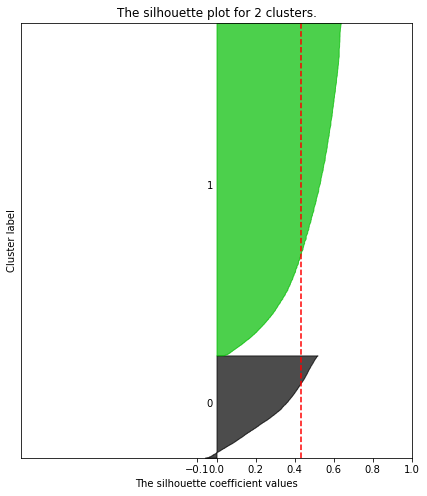

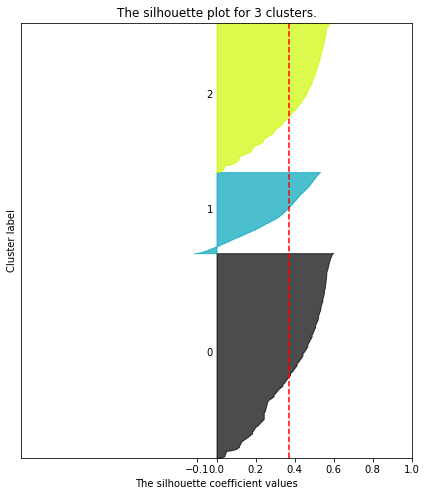

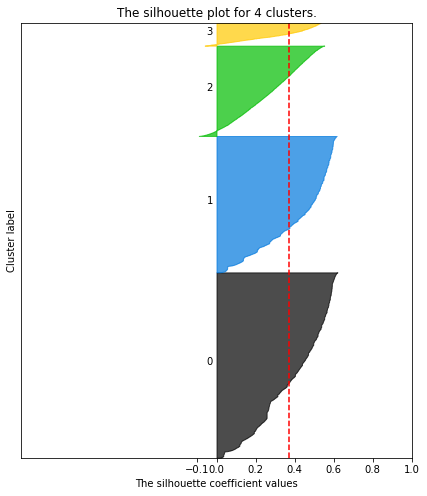

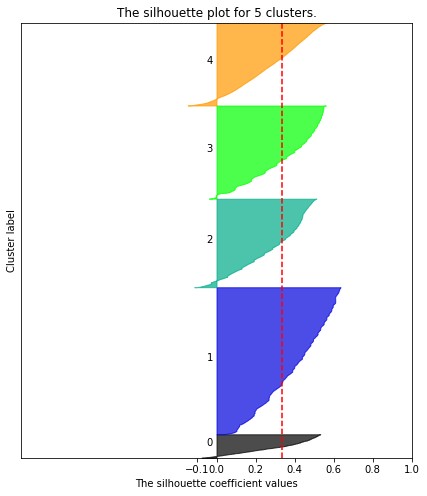

In [42]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(figsize=(7, 8))
    # The 1st subplot is the silhouette plot
    ax.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'For n_clusters = {n_clusters}',
          f'The average silhouette_score is : {round(silhouette_avg, 4)}')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f'The silhouette plot for {n_clusters} clusters.')
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

&emsp;No matter how many clusters the silhouette score is still low. It may indicate that our dataset is not suitable for clustering with KMeans (which is most likely the case since our dataset violates the KMeans assumptions about the variance of the distribution of each attribute (variable) being spherical and all variables having the same variance as well as prior probability for all K clusters beeing the same, ie each cluster having roughly equal number of observations).

### BIRCH
<a id='birch'></a>

&emsp;<b>B</b>alanced <b>I</b>terative <b>R</b>educing and <b>C</b>lustering using <b>H</b>ierarchies (BIRCH) is a clustering algorithm that can cluster large datasets by first generating a small and compact summary of the the large dataset that retains as much information as possible. This smaller summary is then clustered instead of clustering the larger dataset.

&emsp;We will let the algorithm come up with the number of clusters. Also we will leave the threshold at it's default (from scikit-learn documentation: the radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold, otherwise a new subcluster is started).

In [43]:
birch = Birch(n_clusters=None) #by default n_clusters=3
birch.fit(X)
birch.predict(X)

birch_labels = birch.labels_
df['Birch-Labels'] = birch_labels
df['Birch-Labels'].value_counts()

0    83531
Name: Birch-Labels, dtype: int64

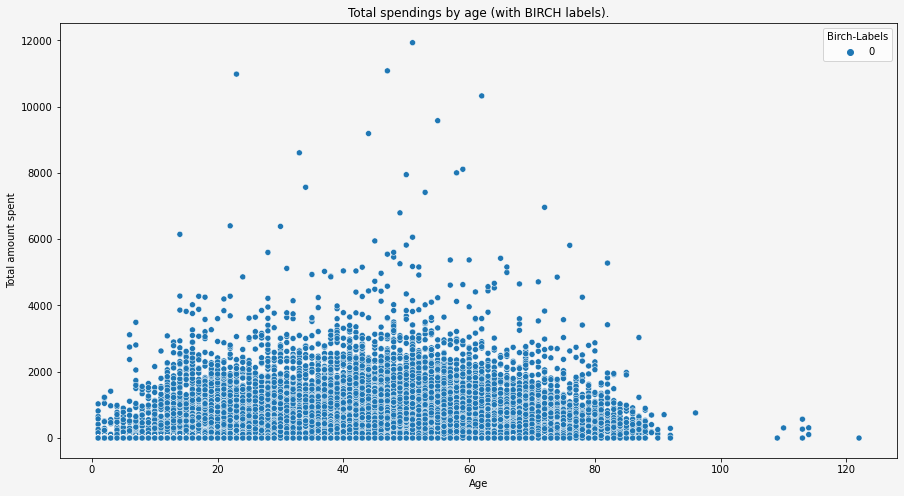

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor('#F5F5F5')

sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], hue=df['Birch-Labels'])
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age')
ax.set_ylabel('Total amount spent')
plt.title('Total spendings by age (with BIRCH labels).')
plt.show()

BIRCH thrown all of our customers into one bucket. We will try various thresholds now.

In [45]:
%%time

thresholds = [0.05, 0.1, 0.2, 0.25]

birch_labels = {}

for t in thresholds:
    birch = Birch(threshold=t, n_clusters=None)
    birch.fit(X)
    birch.predict(X)
    labels = birch.labels_
    birch_labels[f'{t}'] = labels 

birch_df = pd.DataFrame(birch_labels)

birch_df.head()

Wall time: 8.41 s


Threshold: 0.05 
Number of clusters found: 501     
Value counts: 
5      5084
15     3953
16     3595
115    3571
468    3427
       ... 
177       1
457       1
55        1
74        1
0         1
Name: 0.05, Length: 501, dtype: int64


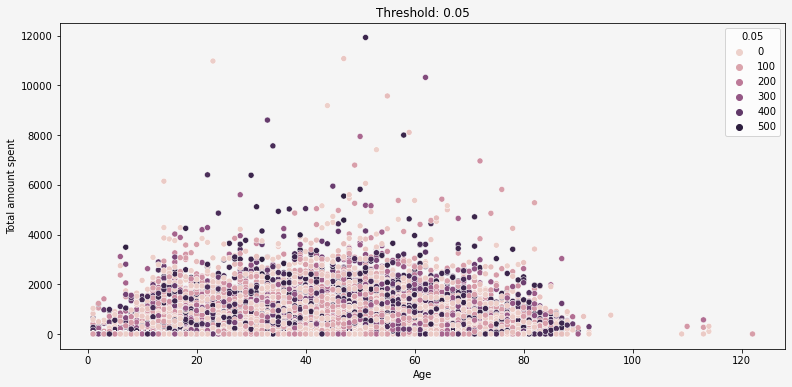

Threshold: 0.1 
Number of clusters found: 71     
Value counts: 
5     14589
9      8261
8      7585
16     5552
7      4783
      ...  
68        1
10        1
20        1
26        1
0         1
Name: 0.1, Length: 71, dtype: int64


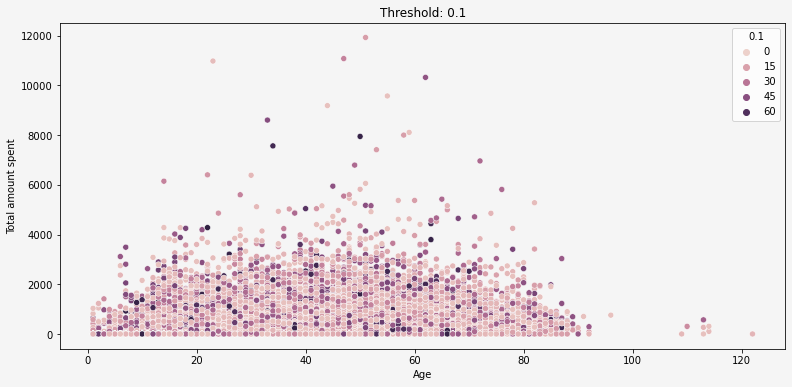

Threshold: 0.2 
Number of clusters found: 4     
Value counts: 
0    38841
3    30395
2    13085
1     1210
Name: 0.2, dtype: int64


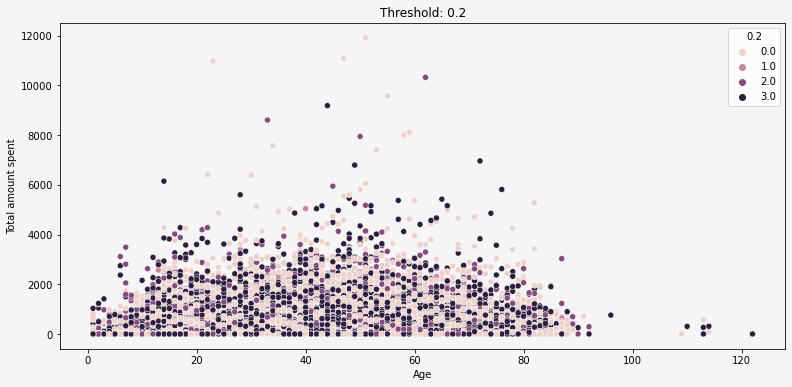

Threshold: 0.25 
Number of clusters found: 1     
Value counts: 
0    83531
Name: 0.25, dtype: int64


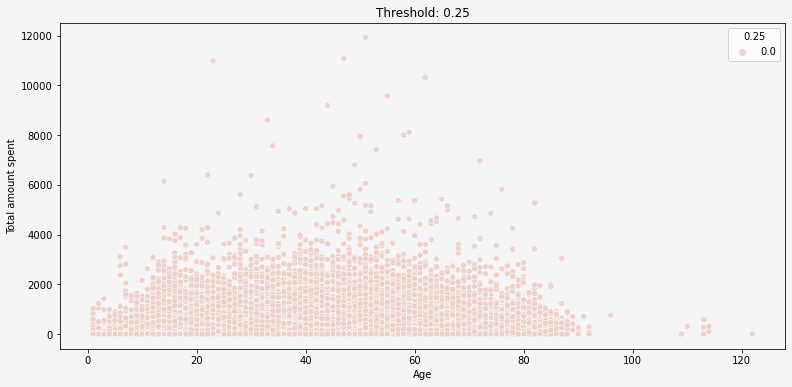

In [46]:
for col in birch_df.columns:
    fig, ax = plt.subplots(figsize=(13, 6))
    fig.set_facecolor('#F5F5F5')
    
    sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], hue=birch_df[col])
    ax.set_facecolor('#F5F5F5')
    ax.set_xlabel('Age')
    ax.set_ylabel('Total amount spent')
    plt.title(f'Threshold: {col}')
    
    print(f'Threshold: {col} \nNumber of clusters found: {birch_df[col].nunique()} \
    \nValue counts: \n{birch_df[col].value_counts()}')
    plt.show()

With a threshold = 0.2 BIRCH classified our customers into 4 gruops. Let's set the number of clusters to 3 so that we can compare it with KMeans.

In [47]:
birch = Birch(threshold=0.2, n_clusters=3)
birch.fit(X)
birch.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
#Overwrite older labels

birch_labels = birch.labels_
df['Birch-Labels'] = birch_labels
df['Birch-Labels'].value_counts()

0    69236
2    13085
1     1210
Name: Birch-Labels, dtype: int64

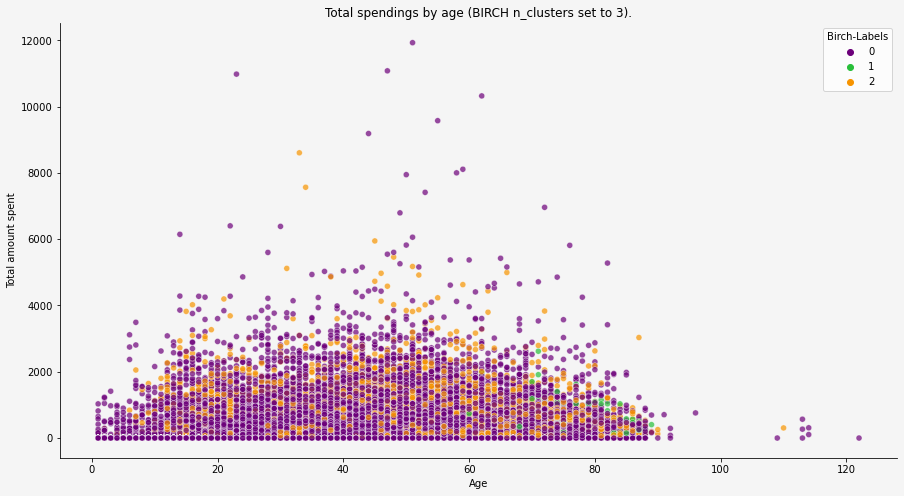

In [49]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor('#F5F5F5')

sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], hue=df['Birch-Labels'], alpha=0.7, palette=palette)
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age')
ax.set_ylabel('Total amount spent')
plt.title('Total spendings by age (BIRCH n_clusters set to 3).')
sns.despine()
plt.show()

In [50]:
round(silhouette_score(X, birch_labels), 4)

0.4221

We can see that label 0 is dominant in the results and that the silhouette score is close to zero which indicates overlapping clusters with samples very close to the decision boundary of the neighboring clusters. Just like before we will group our dataset by labels and check the averages.

In [51]:
birch_avg = df.groupby('Birch-Labels').mean()
birch_avg.drop('ID', axis=1, inplace=True)
birch_avg

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight,Kmean-Labels
Birch-Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,44.026443,445.153042,33.510471,274.409500,59.026985,0.002369,0.000765,0.750144,4.129904,2.138642,381.129730,383.816136,0.049079,0.001473,0.000260,0.000924,0.002946,0.001488,0.014198,0.353588,0.134034,0.000332,0.003568,0.000144,0.086183,333.436485,1.359864,1.380351
1,72.438567,560.342975,435.292562,213.332893,141.499579,0.000000,0.000000,1.010744,4.772727,2.600000,561.826446,562.923967,0.001653,0.000000,0.000000,0.000000,0.000000,0.001653,0.000000,0.260331,0.351240,0.000000,0.000826,0.000000,0.009917,354.832471,1.828099,0.000000
2,50.273519,489.330608,205.096293,436.756942,106.259415,0.000382,0.000000,1.012304,7.400917,3.507375,492.545357,492.806572,0.043332,0.001223,0.000229,0.000688,0.002598,0.002904,0.007337,0.355674,0.168743,0.000382,0.003439,0.000000,0.107528,543.016357,2.086481,0.081162


### Gaussian Mixture
<a id='gmm'></a>

&emsp;A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. Some columns of our data are skewed so we will transform them using NumPy log1p function and adding a constant so they have more normal distribution.<br>
&emsp;First we will plot the BIC (Bayesian information criterion) score for various numbers of components. The lower the score the better.

In [52]:
col_to_log = ['Age', 'AverageLeadTime', 'PersonsNights', 'RoomNights', 'TotalRevenue']
X_gmm = pd.DataFrame()

for col in col_to_log:
    X_gmm[col] = np.log1p(data_prep[col] + 0.1)

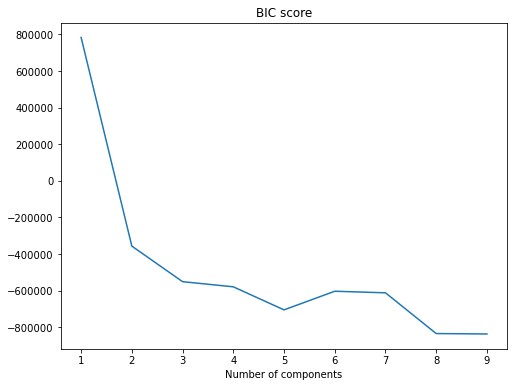

In [53]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_gmm)
          for n in n_components]

plt.figure(figsize=(8, 6))
plt.plot(n_components, [m.bic(X_gmm) for m in models], label='BIC')
plt.title('BIC score')
plt.xlabel('Number of components')
plt.show()

I choose 5 as 8 feels like a lot of clusters.

In [54]:
gmm = GaussianMixture(n_components=5).fit(X_gmm)
gmm_labels = gmm.predict(X_gmm)
print(gmm.converged_)

True


In [55]:
df['GMM-Labels'] = gmm_labels
print(f'Number of clusters found: {df["GMM-Labels"].nunique()}')
df['GMM-Labels'].value_counts()

Number of clusters found: 5


4    31413
1    19877
0    19480
2    10276
3     2485
Name: GMM-Labels, dtype: int64

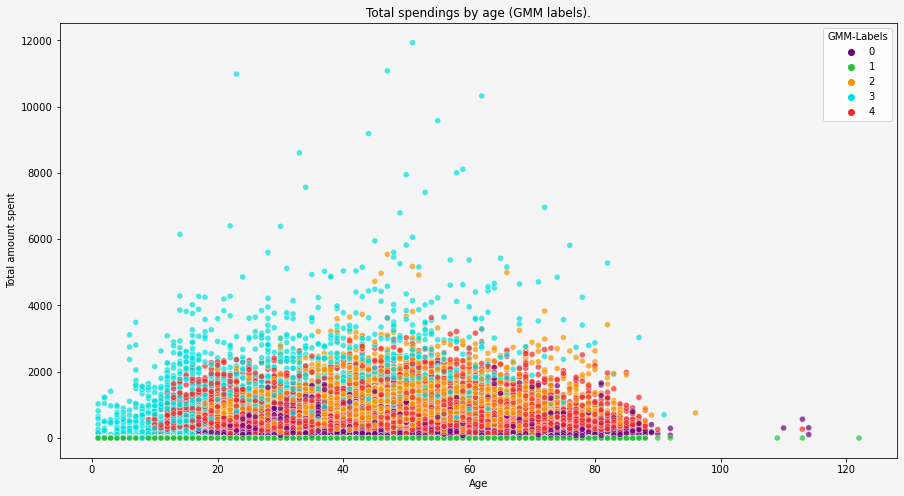

In [56]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor('#F5F5F5')

palette2 = ['#6c007a', '#28bf3a', '#f79400', '#00e0dd', '#f02b2b']
sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], hue=df['GMM-Labels'], alpha=0.7, palette=palette2)
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age')
ax.set_ylabel('Total amount spent')
plt.title('Total spendings by age (GMM labels).')
plt.show()

In [57]:
round(silhouette_score(X_gmm, gmm_labels), 4)

0.2439

The silhouette score is still low. Let's make a final grouping of original dataset by GMM labels.

In [58]:
gmm_avg = df.groupby('GMM-Labels').mean()
gmm_avg.drop('ID', axis=1, inplace=True)
gmm_avg

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight,Kmean-Labels,Birch-Labels
GMM-Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,47.023228,514.696663,54.599846,239.358885,36.399213,0.002105,0.001181,1.034189,2.371561,1.999333,512.930493,516.587731,0.029877,0.000719,0.000257,0.000565,0.001540,0.000616,0.005082,0.287834,0.058984,0.000257,0.002721,0.000051,0.065811,275.758098,1.368390,1.189425,0.232341
1,39.504940,219.988278,0.000000,0.000000,0.000000,0.000101,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.056548,0.001811,0.000101,0.000755,0.003371,0.001660,0.024149,0.366705,0.161694,0.000252,0.002868,0.000252,0.093324,0.000000,0.000000,1.490718,0.000000
2,46.958568,530.922538,98.936454,610.966824,151.165479,0.000779,0.000195,1.032503,12.111327,4.557610,533.347801,535.641884,0.054009,0.002725,0.000292,0.001070,0.004476,0.002336,0.019268,0.363274,0.139646,0.000389,0.004574,0.000097,0.102277,762.132302,2.868021,0.885461,0.589626
3,33.541288,491.466398,59.229779,960.045537,177.514398,0.044668,0.010463,1.542857,6.862777,4.389135,462.852314,495.678068,0.031791,0.000000,0.000000,0.002012,0.000402,0.001610,0.021328,0.306640,0.136016,0.001207,0.004024,0.000000,0.072032,1137.559936,1.895810,1.450302,0.231791
4,48.607574,535.621240,105.149397,370.718944,93.746375,0.000223,0.000064,1.012829,6.393722,3.196861,538.305319,538.762232,0.051794,0.001273,0.000350,0.000987,0.002992,0.002228,0.007927,0.383886,0.183905,0.000350,0.004011,0.000096,0.096107,464.465318,2.000000,0.990927,0.516315


## Averages comparison

Just like before we will set the number of clusters to 3 so that we could compare the results with other averages (yes, components = 3 had worst BIC score than 5, but we do that as an exercise).

In [59]:
gmm = GaussianMixture(n_components=3).fit(X_gmm)
gmm_labels = gmm.predict(X_gmm)
print(gmm.converged_)

True


In [60]:
df['GMM-Labels'] = gmm_labels
print(f'Number of clusters found: {df["GMM-Labels"].nunique()}')
df['GMM-Labels'].value_counts()

Number of clusters found: 3


2    32408
1    31246
0    19877
Name: GMM-Labels, dtype: int64

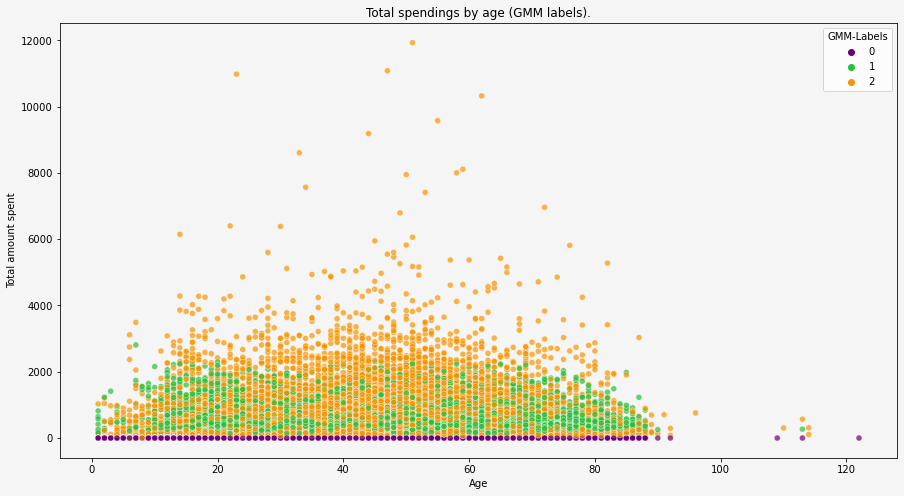

In [61]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor('#F5F5F5')

palette2 = ['#6c007a', '#28bf3a', '#f79400']
sns.scatterplot(x=df['Age'], y=df['TotalRevenue'], hue=df['GMM-Labels'], alpha=0.7, palette=palette2)
ax.set_facecolor('#F5F5F5')
ax.set_xlabel('Age')
ax.set_ylabel('Total amount spent')
plt.title('Total spendings by age (GMM labels).')
plt.show()

In [62]:
gmm_avg = df.groupby('GMM-Labels').mean()
gmm_avg.drop('ID', axis=1, inplace=True)
gmm_avg

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight,Kmean-Labels,Birch-Labels
GMM-Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,39.504940,219.988278,0.000000,0.000000,0.000000,0.000101,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.056548,0.001811,0.000101,0.000755,0.003371,0.001660,0.024149,0.366705,0.161694,0.000252,0.002868,0.000252,0.093324,0.000000,0.000000,1.490718,0.000000
1,48.512804,535.940280,105.403604,362.840459,91.806437,0.000224,0.000064,1.012162,6.390194,3.195097,538.684504,539.079978,0.051463,0.001280,0.000352,0.000992,0.003008,0.002240,0.008097,0.384145,0.183736,0.000352,0.004033,0.000096,0.095628,454.646897,2.000000,0.992863,0.516674
2,46.082878,517.860559,69.028604,420.723294,85.775961,0.004937,0.001574,1.073192,5.828376,3.001635,515.329703,520.834053,0.038108,0.001296,0.000247,0.000833,0.002376,0.001234,0.010676,0.313441,0.091274,0.000370,0.003394,0.000062,0.078468,506.499255,1.887593,1.110158,0.346705


Final dataframe with averages.

In [63]:
avg_df = pd.concat([kmeans_avg, birch_avg, gmm_avg], axis=0)
avg_df.drop(['Kmean-Labels','Birch-Labels'], axis=1, inplace=True)

avg_index = ['K_0', 'K_1', 'K_2', 'BIRCH_0', 'BIRCH_1', 'BIRCH_2', 'GMM_0', 'GMM_1', 'GMM_2']
avg_df.index = avg_index

avg_df

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalRevenue,PersonsRoomNight
K_0,53.251455,496.910511,216.026808,419.765372,108.861748,0.000321,0.000000,1.012986,7.185214,3.420765,499.828608,500.297975,0.040051,0.001286,0.000257,0.000836,0.002122,0.002829,0.006172,0.347991,0.182578,0.000321,0.003472,0.000000,0.099518,528.627120,2.069602
K_1,55.563007,469.383113,31.831587,282.274324,64.321765,0.003484,0.001221,0.790844,4.318057,2.245015,408.799390,412.444507,0.044379,0.001907,0.000331,0.001017,0.002263,0.001577,0.004451,0.348118,0.124059,0.000483,0.004095,0.000051,0.091963,346.596089,1.413505
K_2,28.576633,408.847536,32.056288,256.268729,49.760434,0.000942,0.000174,0.682335,3.734017,1.941199,337.236111,338.635992,0.055800,0.000803,0.000140,0.000698,0.004048,0.001291,0.028197,0.361146,0.146392,0.000140,0.002722,0.000279,0.077540,306.029164,1.252563
BIRCH_0,44.026443,445.153042,33.510471,274.409500,59.026985,0.002369,0.000765,0.750144,4.129904,2.138642,381.129730,383.816136,0.049079,0.001473,0.000260,0.000924,0.002946,0.001488,0.014198,0.353588,0.134034,0.000332,0.003568,0.000144,0.086183,333.436485,1.359864
BIRCH_1,72.438567,560.342975,435.292562,213.332893,141.499579,0.000000,0.000000,1.010744,4.772727,2.600000,561.826446,562.923967,0.001653,0.000000,0.000000,0.000000,0.000000,0.001653,0.000000,0.260331,0.351240,0.000000,0.000826,0.000000,0.009917,354.832471,1.828099
BIRCH_2,50.273519,489.330608,205.096293,436.756942,106.259415,0.000382,0.000000,1.012304,7.400917,3.507375,492.545357,492.806572,0.043332,0.001223,0.000229,0.000688,0.002598,0.002904,0.007337,0.355674,0.168743,0.000382,0.003439,0.000000,0.107528,543.016357,2.086481
GMM_0,39.504940,219.988278,0.000000,0.000000,0.000000,0.000101,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.056548,0.001811,0.000101,0.000755,0.003371,0.001660,0.024149,0.366705,0.161694,0.000252,0.002868,0.000252,0.093324,0.000000,0.000000
GMM_1,48.512804,535.940280,105.403604,362.840459,91.806437,0.000224,0.000064,1.012162,6.390194,3.195097,538.684504,539.079978,0.051463,0.001280,0.000352,0.000992,0.003008,0.002240,0.008097,0.384145,0.183736,0.000352,0.004033,0.000096,0.095628,454.646897,2.000000
GMM_2,46.082878,517.860559,69.028604,420.723294,85.775961,0.004937,0.001574,1.073192,5.828376,3.001635,515.329703,520.834053,0.038108,0.001296,0.000247,0.000833,0.002376,0.001234,0.010676,0.313441,0.091274,0.000370,0.003394,0.000062,0.078468,506.499255,1.887593


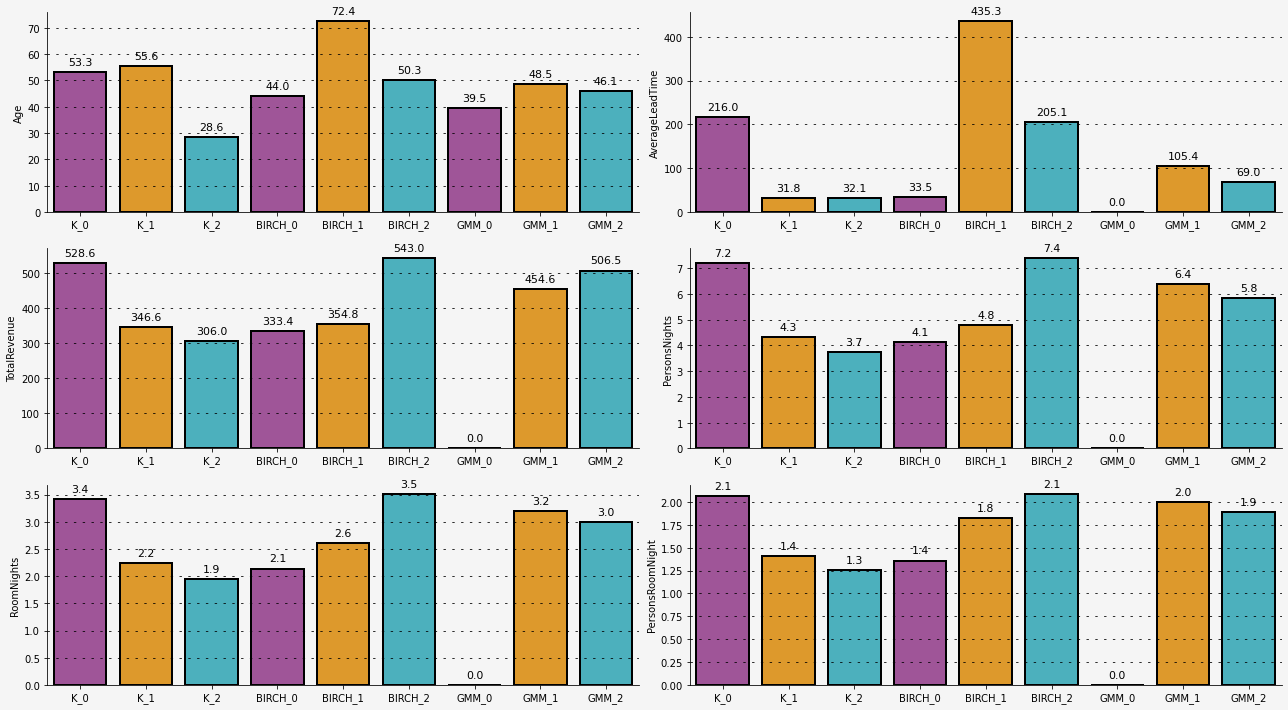

In [64]:
avg_cols = ['Age', 'AverageLeadTime', 'TotalRevenue', 'PersonsNights', 'RoomNights', 'PersonsRoomNight']

avg_palette = ['#AB49A2', # share label 0
               '#FAA00F', # share label 1 
               '#39BFD0'] # share label 2

fig = plt.figure(figsize=(18, 10))
fig.set_facecolor('#F5F5F5')

ax = [None for _ in range(6)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan=2)
ax[1] = plt.subplot2grid((3,4), (0,2), colspan=2)
ax[2] = plt.subplot2grid((3,4), (1,0), colspan=2)
ax[3] = plt.subplot2grid((3,4), (1,2), colspan=2)
ax[4] = plt.subplot2grid((3,4), (2,0), colspan=2)
ax[5] = plt.subplot2grid((3,4), (2,2), colspan=2)

for i, axis in enumerate(ax):

    col = avg_cols[i]
    g = sns.barplot(y=avg_df[col], x=avg_df.index, palette=avg_palette, 
            alpha=1, linewidth=2, edgecolor='black', ax=ax[i])

    axis=g

    for p in axis.patches:
        axis.annotate(f'{round(p.get_height(), 1)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                    textcoords='offset points')

for i in range(6):
    sns.despine()
    ax[i].set_facecolor('#F5F5F5')
    ax[i].xaxis.grid(False, which='major')
    ax[i].yaxis.grid(True, linestyle=':', color='black', dashes=(3, 8))


plt.tight_layout()
plt.show()

We see that the averages for our labels differs from eachother and that there is definately something going on with GMM's label 1.

## Conclusions
<a id='conc'></a>

&emsp;In the end I am somewhat disappointed with the results of our clustering, but I am also sure that with proper algorithms tweaking and some feature engineering we could achive a better outcome. I also think that for somebody with domain knowledge even this kind of resluts may help in making decisions.
<br>&emsp;I hope you enjoy this notebook, thank you for your time. 